In [1]:
import ee
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
ee.Initialize()

In [2]:
#results_df = pd.read_csv('plots/version6/US_results_cleaned_data.csv').set_index('City')
results_df = pd.read_csv('plots/version6/US_results_Tu_vs_TR.csv').set_index('City')
paired_df = pd.read_csv('USpairs2005-2015.csv').set_index('City', drop = False)
paired_df = paired_df[paired_df['Urban distance'] < 0.25]

In [3]:
lcc_english = {
#Water	 
11: 'Open Water- areas of open water, generally with less than 25% cover of vegetation or soil.', 
12: 'Perennial Ice/Snow- areas characterized by a perennial cover of ice and/or snow, generally greater than 25% of total cover.',
#Developed	 
21: 'Developed, Open Space- areas with a mixture of some constructed materials, but mostly vegetation in the form of lawn grasses. Impervious surfaces account for less than 20% of total cover. These areas most commonly include large-lot single-family housing units, parks, golf courses, and vegetation planted in developed settings for recreation, erosion control, or aesthetic purposes.',
22: 'Developed, Low Intensity- areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 20% to 49% percent of total cover. These areas most commonly include single-family housing units.',
23: 'Developed, Medium Intensity -areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 50% to 79% of the total cover. These areas most commonly include single-family housing units.',
24: 'Developed High Intensity-highly developed areas where people reside or work in high numbers. Examples include apartment complexes, row houses and commercial/industrial. Impervious surfaces account for 80% to 100% of the total cover.',
#Barren	 
31: 'Barren Land (Rock/Sand/Clay) - areas of bedrock, desert pavement, scarps, talus, slides, volcanic material, glacial debris, sand dunes, strip mines, gravel pits and other accumulations of earthen material. Generally, vegetation accounts for less than 15% of total cover.',
#Forest	 
41: 'Deciduous Forest- areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. More than 75% of the tree species shed foliage simultaneously in response to seasonal change.',
42: 'Evergreen Forest- areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. More than 75% of the tree species maintain their leaves all year. Canopy is never without green foliage.',
43: 'Mixed Forest- areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. Neither deciduous nor evergreen species are greater than 75% of total tree cover.',
#Shrubland	 
51: 'Dwarf Scrub- Alaska only areas dominated by shrubs less than 20 centimeters tall with shrub canopy typically greater than 20% of total vegetation. This type is often co-associated with grasses, sedges, herbs, and non-vascular vegetation.',
52: 'Shrub/Scrub- areas dominated by shrubs; less than 5 meters tall with shrub canopy typically greater than 20% of total vegetation. This class includes true shrubs, young trees in an early successional stage or trees stunted from environmental conditions.',
#Herbaceous 	 
71: 'Grassland/Herbaceous- areas dominated by gramanoid or herbaceous vegetation, generally greater than 80% of total vegetation. These areas are not subject to intensive management such as tilling, but can be utilized for grazing.',
72: 'Sedge/Herbaceous- Alaska only areas dominated by sedges and forbs, generally greater than 80% of total vegetation. This type can occur with significant other grasses or other grass like plants, and includes sedge tundra, and sedge tussock tundra.',
73: 'Lichens- Alaska only areas dominated by fruticose or foliose lichens generally greater than 80% of total vegetation.',
74: 'Moss- Alaska only areas dominated by mosses, generally greater than 80% of total vegetation.',
#Planted/Cultivated	 
81: 'Pasture/Hay-areas of grasses, legumes, or grass-legume mixtures planted for livestock grazing or the production of seed or hay crops, typically on a perennial cycle. Pasture/hay vegetation accounts for greater than 20% of total vegetation.',
82: 'Cultivated Crops -areas used for the production of annual crops, such as corn, soybeans, vegetables, tobacco, and cotton, and also perennial woody crops such as orchards and vineyards. Crop vegetation accounts for greater than 20% of total vegetation. This class also includes all land being actively tilled.',
#Wetlands	 
90: 'Woody Wetlands- areas where forest or shrubland vegetation accounts for greater than 20% of vegetative cover and the soil or substrate is periodically saturated with or covered with water.',
95: 'Emergent Herbaceous Wetlands- Areas where perennial herbaceous vegetation accounts for greater than 80% of vegetative cover and the soil or substrate is periodically saturated with or covered with water.',
np.nan: 'unclassifiable'
}

In [4]:
# import the 2011 nlcd2011 national land cover database 
# metadata at: www.mrlc.gov/nlcd11_leg.php
# classes 21-24 are barren
lcc_df = pd.DataFrame(index = paired_df.index, columns = ['UrbanStationLCC', 'LCC_English'])
nlcd = ee.Image('USGS/NLCD/NLCD2011').select('landcover')
for city in paired_df.index: 
    # create a EE geomtetry object of the lat/lon of the urban weather station
    point = ee.Geometry.Point([paired_df.loc[city]['Urban Lon'], 
                          paired_df.loc[city]['Urban Lat']])
    # sample the data of the NLCD at this location
    data = nlcd.sample(point,30).getInfo()
    try: 
        lcc = data['features'][0]['properties']['landcover']
    except IndexError: 
        lcc = np.nan
    lcc_df.loc[city]['UrbanStationLCC'] = lcc
    lcc_df.loc[city]['LCC_English'] = lcc_english[lcc]

In [9]:
paired_df['urban_lcc'] = lcc_df['UrbanStationLCC']
paired_df.to_csv('USpairs2005-2015.csv')

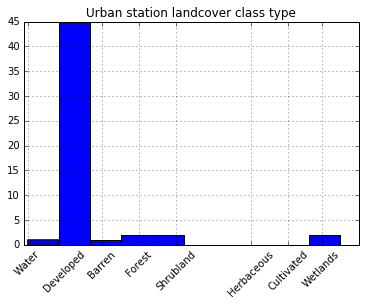

In [183]:
lcc_df['UrbanStationLCC'].astype(float).hist()
plt.title('Urban station landcover class type')
handles = plt.xticks([11, 21,31, 41, 51, 71, 81, 90], 
           ['Water', 'Developed', 'Barren', 'Forest', 'Shrubland', 'Herbaceous', 'Cultivated', 'Wetlands'], 
                    rotation = 45)
plt.savefig

Most of our stations are classified as urban landcovers: 

In [7]:
urban_landcovers = lcc_df[(lcc_df>  20) & (lcc_df <=  24)]['UrbanStationLCC'].dropna().shape[0]
total_cities = paired_df.shape[0]
print('%i/%i or %2.2f percent are developed'%(urban_landcovers, total_cities, 100*float(urban_landcovers)/float(total_cities)))

45/54 or 83.33 percent are developed


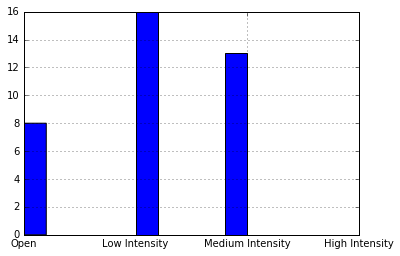

In [118]:
# plot the urban landcover classes 
lcc_df[(lcc_df>  20) & (lcc_df <  24)]['UrbanStationLCC'].hist()
handles = plt.xticks([21, 22, 23, 24], ['Open', 'Low Intensity', 'Medium Intensity', 'High Intensity'])

In [106]:
lcc_df[(lcc_df< 20) | (lcc_df > 24)].dropna()

,UrbanStationLCC,LCC_English
City,,
Fort Lauderdale,95,Emergent Herbaceous Wetlands- Areas where pere...
Providence,95,Emergent Herbaceous Wetlands- Areas where pere...
Tucson,52,Shrub/Scrub- areas dominated by shrubs; less t...
Albuquerque,52,Shrub/Scrub- areas dominated by shrubs; less t...
Austin,42,Evergreen Forest- areas dominated by trees gen...
Las Vegas,31,Barren Land (Rock/Sand/Clay) - areas of bedroc...
Pittsburgh,11,"Open Water- areas of open water, generally wit..."
New York,43,Mixed Forest- areas dominated by trees general...


In [60]:
non_developed = lcc_df[(lcc_df< 20) | (lcc_df > 24)].dropna().index
developed = lcc_df[(lcc_df>  20) & (lcc_df <  24)]['UrbanStationLCC'].dropna().index

In [61]:
non_urban_landcovers = lcc_df[(lcc_df< 20) | (lcc_df > 24)].dropna().shape[0]
total_cities = paired_df.shape[0]
print('%i/%i or %2.2f percent are others'%(non_urban_landcovers, total_cities , 100*float(non_urban_landcovers)/float(total_cities)))

6/54 or 11.11 percent are others


In [159]:
paired_df.loc[lcc_df[(lcc_df< 20) | (lcc_df > 24)].dropna().index]['Urban distance']

City
Fort Lauderdale    0.036001
Providence         0.179342
Tucson             0.135087
Albuquerque        0.076637
Austin             0.044281
Las Vegas          0.025026
Pittsburgh         0.109237
New York           0.030109
Name: Urban distance, dtype: float64

0.686154724226


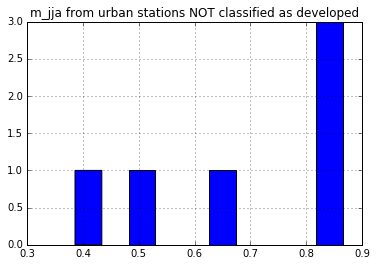

In [62]:
results_df.loc[non_developed]['slope'].hist()
print(results_df.loc[non_developed]['slope'].mean())
plt.title('m_jja from urban stations NOT classified as developed')

0.867669049679


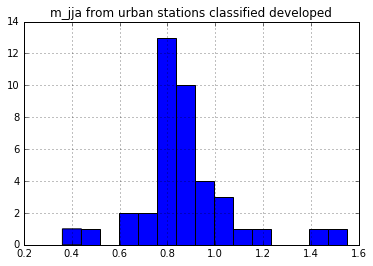

In [77]:
results_df.loc[developed]['slope'].hist(bins=15)
print(results_df.loc[developed]['slope'].mean())
plt.title('m_jja from urban stations classified developed')

0.871898278427


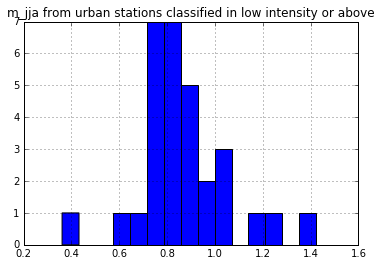

In [76]:
# super developed 
sdeveloped = lcc_df[(lcc_df>  21) & (lcc_df <  24)]['UrbanStationLCC'].dropna().index
results_df.loc[sdeveloped]['slope'].hist(bins =15)
print(results_df.loc[sdeveloped]['slope'].mean())
plt.title('m_jja from urban stations classified in low intensity or above')

0.845505075778


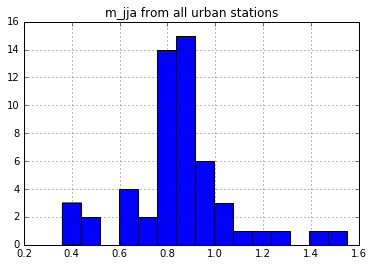

In [75]:
results_df['slope'].hist(bins = 15)
print(results_df['slope'].mean())
plt.title('m_jja from all urban stations')

### What if we change to look at a larger area

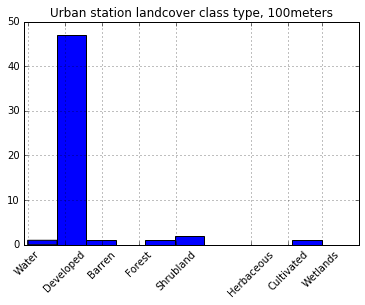

In [48]:
# import the 2011 nlcd2011 national land cover database 
# metadata at: www.mrlc.gov/nlcd11_leg.php
# classes 21-24 are barren
lcc_df = pd.DataFrame(index = paired_df.index, columns = ['UrbanStationLCC', 'LCC_English'])
nlcd = ee.Image('USGS/NLCD/NLCD2011').select('landcover')
for city in paired_df.index: 
    # create a EE geomtetry object of the lat/lon of the urban weather station
    point = ee.Geometry.Point([paired_df.loc[city]['Urban Lon'], 
                          paired_df.loc[city]['Urban Lat']])
    # sample the data of the NLCD at this location
    data = nlcd.sample(point,100).getInfo()
    try: 
        lcc = data['features'][0]['properties']['landcover']
    except IndexError: 
        lcc = np.nan
    lcc_df.loc[city]['UrbanStationLCC'] = lcc
    lcc_df.loc[city]['LCC_English'] = lcc_english[lcc]
lcc_df['UrbanStationLCC'].astype(float).hist()
plt.title('Urban station landcover class type, 100meters')
handles = plt.xticks([11, 21,31, 41, 51, 71, 81, 90], 
           ['Water', 'Developed', 'Barren', 'Forest', 'Shrubland', 'Herbaceous', 'Cultivated', 'Wetlands'], 
                    rotation = 45)

In [49]:
lcc_df[(lcc_df< 20) | (lcc_df > 24)].dropna()

,UrbanStationLCC,LCC_English
City,,
Fort Lauderdale,90,Woody Wetlands- areas where forest or shrublan...
Tucson,52,Shrub/Scrub- areas dominated by shrubs; less t...
Las Vegas,31,Barren Land (Rock/Sand/Clay) - areas of bedroc...
Salt Lake City,52,Shrub/Scrub- areas dominated by shrubs; less t...
Pittsburgh,11,"Open Water- areas of open water, generally wit..."
New York,43,Mixed Forest- areas dominated by trees general...


In [36]:
lcc_df[(lcc_df< 20) | (lcc_df > 24)].dropna()

,UrbanStationLCC,LCC_English
City,,
Fort Lauderdale,90,Woody Wetlands- areas where forest or shrublan...
Tucson,52,Shrub/Scrub- areas dominated by shrubs; less t...
Las Vegas,31,Barren Land (Rock/Sand/Clay) - areas of bedroc...
Salt Lake City,52,Shrub/Scrub- areas dominated by shrubs; less t...
Pittsburgh,11,"Open Water- areas of open water, generally wit..."
New York,43,Mixed Forest- areas dominated by trees general...


In [58]:
paired_df.loc[lcc_df[(lcc_df< 20) | (lcc_df > 24)].dropna().index]

,Unnamed: 0,City,Urban station,Urban Lat,Urban Lon,Urban brightness,Urban start,Urban end,Rural station,Rural Lat,Rural Lon,Rural brightness,Rural start,Rural end,Urban distance,Rural distance
City,,,,,,,,,,,,,,,,
Fort Lauderdale,4,Fort Lauderdale,USC00083168,26.140,-80.106,63.0,1952-04-01,2016-09-30,USR0000FCAC,25.390,-80.680,4.0,1999-12-01,2016-11-30,0.036001,0.919939
Tucson,19,Tucson,USR0000ASAG,32.316,-110.813,47.0,1995-06-01,2016-08-31,USR0000ASOL,32.403,-110.711,4.0,1999-04-01,2016-10-31,0.135087,0.266911
Las Vegas,34,Las Vegas,USW00053123,36.211,-115.195,63.0,2000-10-01,2016-06-30,USC00262243,36.438,-115.360,5.0,1940-04-01,2016-12-31,0.025026,0.267551
Salt Lake City,36,Salt Lake City,USC00421759,40.618,-111.783,52.0,1941-09-01,2016-09-30,USS0011J37S,40.870,-111.720,7.0,1993-10-01,2016-10-31,0.215124,0.230529
Pittsburgh,48,Pittsburgh,USC00362574,40.501,-80.083,60.0,1991-09-01,2016-10-31,USC00365212,40.458,-79.450,10.0,1989-07-01,2016-07-31,0.109237,0.550698
New York,69,New York,USW00094728,40.778,-73.969,63.0,1876-01-01 00:00:00,2016-08-31,USC00281582,41.034,-74.423,25.0,1893-04-01 00:00:00,2017-01-31,0.030109,0.526215


In [52]:
lcc_df[(lcc_df< 20) | (lcc_df > 24)].dropna().shape[0], float(lcc_df.shape[0])

(6, 54.0)

In [53]:
54-6

48

In [51]:
data = nlcd.sample(point,50).getInfo()
data['features'][0]['properties']['landcover']

43

In [27]:
data = nlcd.sample(point,30).getInfo()
data['features'][0]['properties']['landcover']

41

### Do this for rural areas

In [10]:
# import the 2011 nlcd2011 national land cover database 
# metadata at: www.mrlc.gov/nlcd11_leg.php
# classes 21-24 are barren
lcc_r_df = pd.DataFrame(index = paired_df.index, columns = ['RuralStationLCC', 'LCC_English'])
nlcd = ee.Image('USGS/NLCD/NLCD2011').select('landcover')
for city in paired_df.index: 
    # create a EE geomtetry object of the lat/lon of the urban weather station
    point = ee.Geometry.Point([paired_df.loc[city]['Rural Lon'], 
                          paired_df.loc[city]['Rural Lat']])
    # sample the data of the NLCD at this location
    data = nlcd.sample(point,30).getInfo()
    try: 
        lcc = data['features'][0]['properties']['landcover']
    except IndexError: 
        lcc = np.nan
    lcc_r_df.loc[city]['RuralStationLCC'] = lcc
    lcc_r_df.loc[city]['LCC_English'] = lcc_english[lcc]

In [12]:
paired_df['rural_lcc'] = lcc_r_df['RuralStationLCC']
paired_df.to_csv('USpairs2005-2015.csv')

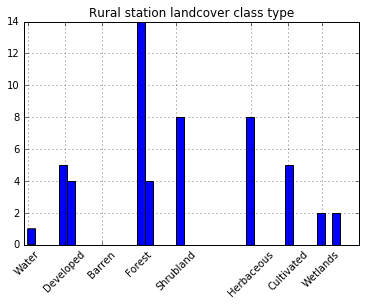

In [22]:
lcc_r_df['RuralStationLCC'].astype(float).hist(bins = 40)
plt.title('Rural station landcover class type')
handles = plt.xticks([11, 21,31, 41, 51, 71, 81, 90], 
           ['Water', 'Developed', 'Barren', 'Forest', 'Shrubland', 'Herbaceous', 'Cultivated', 'Wetlands'], 
                    rotation = 45)

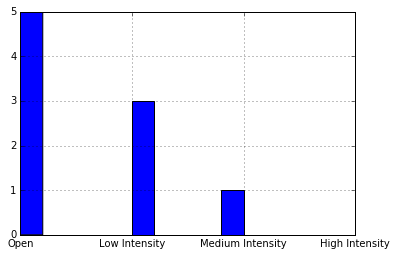

In [23]:
# plot the urban landcover classes 
lcc_r_df[(lcc_r_df>  20) & (lcc_r_df <  24)]['RuralStationLCC'].hist()
handles = plt.xticks([21, 22, 23, 24], ['Open', 'Low Intensity', 'Medium Intensity', 'High Intensity'])

In [79]:
lcc_r_df[(lcc_r_df>  20) & (lcc_r_df <  24)]['RuralStationLCC'].dropna()

City
Providence     22
Kansas City    21
Sacramento     21
Portland       23
Cleveland      21
Nashville      21
St. Louis      22
Detroit        22
Miami          21
Name: RuralStationLCC, dtype: object

In [80]:
lcc_english[23]

'Developed, Medium Intensity -areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 50% to 79% of the total cover. These areas most commonly include single-family housing units.'

In [57]:
lcc_english[21]

'Developed, Open Space- areas with a mixture of some constructed materials, but mostly vegetation in the form of lawn grasses. Impervious surfaces account for less than 20% of total cover. These areas most commonly include large-lot single-family housing units, parks, golf courses, and vegetation planted in developed settings for recreation, erosion control, or aesthetic purposes.'